# **Fashion-MNIST with `CNN`(s)**

> Here, we will solve a very common Computer Vision project `Fashion MNIST` using `CNN`(Convolutional Neural Network).

'''

* `Fashion MNIST` is a `Image Classification` dataset with `28x28` grayscale images of `10` Fashion categories.
* Here, we will build a` Deep Learning model` using `Convolutional Neural Networks (CNNs)` to solve this Image Classification problem.

![Image](https://thiagolcmelo.github.io/assets/img/fashion-mnist.png)

***
***

### **Importing Libraries**

We will import some basic python libraires, such as:

* `Numpy` - a Python library used for working with arrays.
* `Pandas` - a Python library used for data analysis and manipulation.
* `Matplotlib` - a plotting library for the Python programming language and its numerical mathematics extension NumPy.
* Additionally, `%matplotlib inline` is a magic command in Jupyter Notebook that allows you to display plots in the notebook itself. It is used to set the backend of matplotlib to the inline backend.
* `Pyplot` - a module in the Matplotlib library which provides a convenient interface for creating plots and charts.
* `Tensorflow` - a free and open-source software library for machine learning and artificial intelligence.
* `Keras` - an open-source high-level neural network library, which is written in Python.

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import json

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, Activation, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn for evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Set matplotlib to display inline in the notebook
%matplotlib inline

2025-05-01 15:20:57.682805: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### **Importing Dataset**

* Here we import Fashion MNIST dataset from `keras.datasets`.
* There are `60,000` Train images and labels and `10,000` for Test.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

* Also we will make a `list` of the `10 classes` (clothing categories). We will later use it to `predict` using our Model.

In [3]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

### **Reshaping Data**

* We will reshape our Train and Test Image dataset.
* `60,000` and `10,000` are the number of images for `Train` and `Test` respectively.
* `28,28` are the dimensions of the images in `pixels`.
* And since the images are in `grayscale`, they only need `1` colour channel.

In [4]:
X_train_full = X_train_full.reshape((60000, 28,28, 1))
X_test = X_test.reshape((10000, 28,28, 1))

### **Split the data into Train/ Validation/ Test Datasets**

* In the earlier step of importing the date, we had 60,000 datasets or Training and 10,000 Test datasets.
* Now we further split the Training data into Train/ Validation. Here is how each type of dataset is used in Deep Learning.

Use of each each type of Dataset in Deep Learning:-

* `Training Data` - used for Training model.
* `Validation Data` - used for tuning the Hyper-parameters and evaluate the Models.
* `Test Data` - used to test the Model after the Model has been trained.

'''

* We will take first `5000` images and labels  out of the `60,000` as `Validation` dataset, and the rest for the model to `Train` on.

In [5]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

### **Class Distribution Visualization**

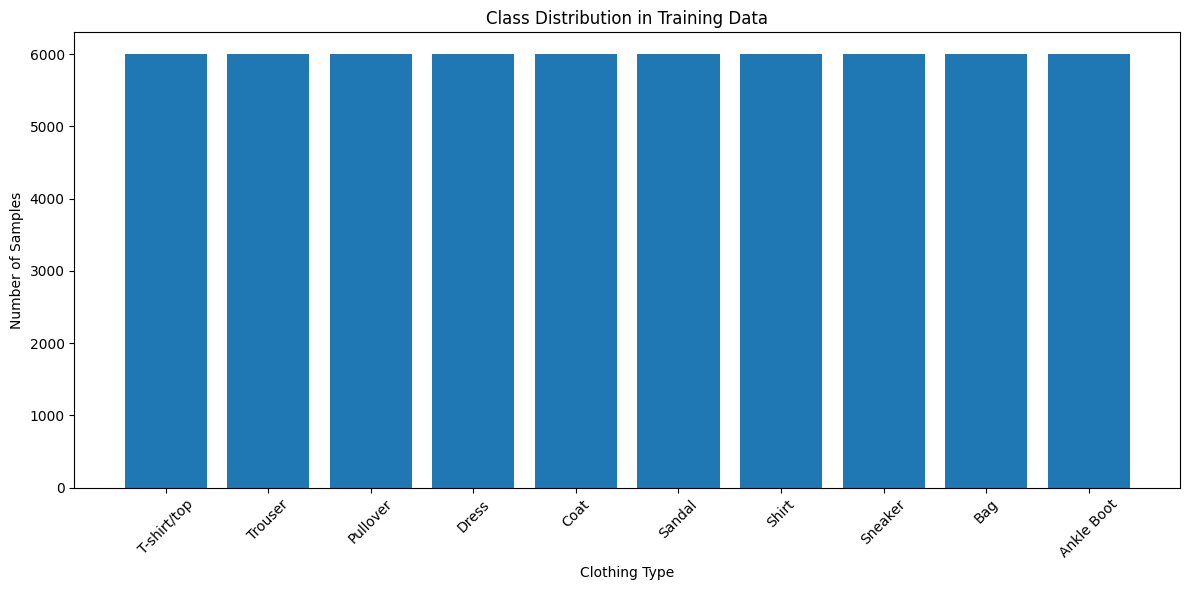

Class Distribution:
T-shirt/top: 6000 samples (10.0%)
Trouser: 6000 samples (10.0%)
Pullover: 6000 samples (10.0%)
Dress: 6000 samples (10.0%)
Coat: 6000 samples (10.0%)
Sandal: 6000 samples (10.0%)
Shirt: 6000 samples (10.0%)
Sneaker: 6000 samples (10.0%)
Bag: 6000 samples (10.0%)
Ankle Boot: 6000 samples (10.0%)


In [6]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
class_counts = np.bincount(y_train_full)
plt.bar(range(len(class_names)), class_counts)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.title('Class Distribution in Training Data')
plt.xlabel('Clothing Type')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

# Calculate and print class distribution
print("Class Distribution:")
for i, name in enumerate(class_names):
    print(f"{name}: {class_counts[i]} samples ({class_counts[i]/len(y_train_full)*100:.1f}%)")

### **Data Augmentation**

> `Data Augmentation` is a technique used in machine learning to `reduce overfitting` when training a machine learning model by training models on several `slightly-modified` copies of `existing data`.

'''

We will perform `Data Augmentation` on `Train` and `Validation` images using following Augmentation:-

* `rescale=1./255` - used to convert the pixels in range `[0,255]` to range `[0,1]`. This process is also called `Normalizing the Input`.
* `rotation_range=20` - used to `rotate` the image by `0 to 20 degrees`. This method of augmentation rotates the pixels of the image.
* `width_shift_range=0.2` - used to `shift` the image in the `horizontal` direction.
* `height_shift_range=0.2` - used to `shift` the image in the `vertical` direction.
* `shear_range=0.2` - used to apply `shear` transformation to the image. `Shear` is a transformation that `shifts the rows or columns` of an image or a video frame by gradually `increasing the offset` from left to right or right to left.
* `zoom_range=0.2` - used to apply `zoom` transformation to the image.
* `horizontal_flip=True` - used to `flip` the image `horizontally`.

In [7]:
# Enhanced data augmentation with CutOut
class RandomErasing(object):
    def __init__(self, probability=0.5, sl=0.02, sh=0.2, r1=0.3, r2=1/0.3):
        self.probability = probability
        self.sl = sl
        self.sh = sh
        self.r1 = r1
        self.r2 = r2
        
    def __call__(self, img):
        if np.random.random() > self.probability:
            return img
            
        img_h, img_w, _ = img.shape
        
        # Area of erasing region
        S = img_h * img_w
        S_e = np.random.uniform(self.sl, self.sh) * S
        
        # Aspect ratio
        r_e = np.random.uniform(self.r1, self.r2)
        h_e = int(np.sqrt(S_e * r_e))
        w_e = int(np.sqrt(S_e / r_e))
        
        # Top-left corner
        x = np.random.randint(0, img_w - w_e + 1)
        y = np.random.randint(0, img_h - h_e + 1)
        
        # Create a copy to avoid modifying the original
        img_erased = img.copy()
        # Erase region with black (0)
        img_erased[y:y+h_e, x:x+w_e, :] = 0
        
        return img_erased

In [8]:
# Define cutout instance
cutout = RandomErasing(probability=0.5, sl=0.02, sh=0.2)

# Custom preprocessing function that applies both normalization and CutOut
def preprocess_with_cutout(image):
    # First normalize the image
    image = image / 255.0
    # Then apply cutout (only during training)
    if np.random.random() < 0.5:  # Apply to ~50% of training images
        image = cutout(image)
    return image

In [9]:
# Generating batches of tensor image data with integrated CutOut
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_with_cutout,
    rotation_range=15,  
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data only gets normalized without augmentation
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = validation_datagen.flow(X_valid, y_valid, batch_size=32)

### **Model Architecture**

* Here we will build a `Convolutional Neural Network` using keras `Sequential API`.

In [10]:
# Enhanced model architecture with batch normalization
model = keras.models.Sequential()

# First convolutional block
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding="same", input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

# Second convolutional block
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

# Third convolutional block
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

# Classification head
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

2025-05-01 15:20:59.679638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 15:20:59.687587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 15:20:59.687656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 15:20:59.693321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 15:20:59.693403: I tensorflow/compile

#### **Architecture Explained**

**1.** `Conv2D [2D Convolutional Neural Network]` - There are `3 Conv2D` networks. These networks are designed to progressively learn more complex features from the input images:

* `filters` - We use an increasing number of filters (32→64→128) to capture progressively more complex patterns. The initial layer with 32 filters detects basic patterns like edges, textures, and simple shapes. The middle layer with 64 filters combines these basic features to form more complex patterns like clothing outlines. The final layer with 128 filters identifies high-level features specific to different clothing items.

* `kernel_size` - The kernel_size of (3,3) provides a balance between capturing local patterns and computational efficiency. These 3×3 filters scan the entire image to detect relevant features.

* `strides` - Using a stride of 1 ensures we don't miss any spatial information, as the filter moves one pixel at a time during convolution.

* `padding` - Setting padding to "same" preserves the spatial dimensions of our feature maps, ensuring we don't lose information at the image borders.

* `activation` - The ReLU (Rectified Linear Unit) activation function introduces non-linearity, allowing the network to learn complex patterns. ReLU is defined as f(x) = max(0,x), which outputs 0 for negative inputs and passes through positive values unchanged.

* `input_shape` - The first layer takes input with shape (28,28,1), representing the width, height, and channel dimensions of our grayscale Fashion MNIST images.

**2.** `MaxPooling2D` - After each convolutional layer, MaxPooling2D reduces the spatial dimensions of our feature maps:

* Each MaxPooling2D layer with pool size (2,2) reduces the width and height by half, keeping only the maximum value from each 2×2 region.
* This downsampling serves multiple purposes:
  * Reducing computational complexity by decreasing the number of parameters
  * Creating a form of translational invariance, helping the model recognize objects regardless of their exact position
  * Focusing on the most important features while discarding less relevant details
  * Each successive pooling layer increases the receptive field, allowing deeper layers to "see" larger portions of the original image

**3.** `Dropout` - Added strategically after each pooling layer and the dense layer:

* Dropout is a powerful regularization technique that randomly deactivates a percentage of neurons during each training iteration.
* We use a 25% dropout rate (0.25) after each convolutional block to prevent overfitting.
* A higher dropout rate of 50% (0.5) is applied after the dense layer, where the majority of model parameters reside.
* Benefits of dropout include:
  * Preventing co-adaptation of neurons (neurons becoming too dependent on each other)
  * Creating an effect similar to ensemble learning, as each training batch effectively trains a slightly different network
  * Forcing the network to learn more robust features that don't rely on specific neuron combinations

**4.** `Flatten` - The Flatten layer transforms our 3D feature maps (width × height × channels) into a 1D vector:

* After the final convolutional block, we have feature maps of reduced spatial dimensions but increased depth (more channels).
* The Flatten layer takes these feature maps and stretches them into a single long vector.
* This transformation is necessary to connect the convolutional layers to the fully connected (Dense) layers.
* The flattening preserves all the extracted features while changing only their arrangement.

**5.** `Dense` - We use two fully connected layers for final classification:

* The first Dense layer has 512 neurons with ReLU activation:
  * This layer interprets the high-level features extracted by the convolutional layers
  * Its large number of neurons gives it the capacity to learn complex combinations of features
  * The ReLU activation allows for non-linear separations in the feature space

* The final Dense layer has 10 neurons (one for each clothing category) with softmax activation:
  * Softmax transforms the raw outputs into a probability distribution over the 10 classes
  * This ensures all outputs sum to 1 and fall between 0 and 1
  * The neuron with the highest activation represents the model's classification

This architecture balances model complexity with regularization, creating a network deep enough to learn the distinguishing features of clothing items while including dropout to prevent overfitting and ensure good generalization to unseen examples.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1

#### **Model Summary Analysis**

In [12]:
# Calculate total parameters
trainable_params = sum([np.prod(layer.get_weights()[0].shape) + np.prod(layer.get_weights()[1].shape if len(layer.get_weights()) > 1 else []) for layer in model.layers if layer.trainable_weights])
print(f"Total trainable parameters: {trainable_params:,}")

# Print per-layer parameter count for better understanding
print("\nParameter distribution by layer:")
for i, layer in enumerate(model.layers):
    if layer.trainable_weights:
        params = sum([np.prod(w.shape) for w in layer.get_weights()])
        print(f"Layer {i} ({layer.__class__.__name__}): {params:,} parameters ({params/trainable_params*100:.2f}%)")

Total trainable parameters: 689,610

Parameter distribution by layer:
Layer 0 (Conv2D): 320 parameters (0.05%)
Layer 1 (BatchNormalization): 128 parameters (0.02%)
Layer 5 (Conv2D): 18,496 parameters (2.68%)
Layer 6 (BatchNormalization): 256 parameters (0.04%)
Layer 10 (Conv2D): 73,856 parameters (10.71%)
Layer 11 (BatchNormalization): 512 parameters (0.07%)
Layer 16 (Dense): 590,336 parameters (85.60%)
Layer 17 (BatchNormalization): 2,048 parameters (0.30%)
Layer 20 (Dense): 5,130 parameters (0.74%)


### **Callbacks**

* We will also use some `Callbacks` to improve our effectiveness and efficiency in training the Model.

> `Callbacks` are functions that can be passed to a neural network `during training` to perform certain `actions at specific points` during the `training` process.

* We will use following Callbacks -

1. `early_stopping` - The `EarlyStopping` callback is a Keras callback that can be used to `stop the training process early` if the monitored value stops improving. Here we monitor `val_loss` and use `10` as `patience` value, which means the callback will wait `10 epochs` before executing.
2. `model_checkpoint` - The `ModelCheckpoint` callback is a Keras callback that can be used to `save the weights` of the neural network at certain intervals during training. Here we will `save only best model`.
3. `reduce_lr_on_plateau` - ReduceLROnPlateau is a callback that `monitors a quantity` and if no improvement is seen for a patience number of epochs, the `learning rate is reduced`. Here we reduce the learning rate by `10 percent`.
4. `tensorboard` - TensorBoard is a `visualization tool` provided with TensorFlow. This callback `logs events` for TensorBoard, including metrics summary plots, training graph visualization, weight histograms, and sampled profiling.

In [13]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True,
    mode='max'
)

model_checkpoint = ModelCheckpoint('./custom_model/best_model.h5', save_best_only=True)

reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.001,
    min_lr=1e-6
)

class LRTracker(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Access learning rate safely using the current value
        lr = self.model.optimizer.learning_rate
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f"\nLearning rate at epoch {epoch+1}: {lr:.6f}")

lr_tracker = LRTracker()

tensorboard = TensorBoard(log_dir='./logs')

callbacks = [early_stopping, model_checkpoint, reduce_lr_on_plateau, tensorboard, lr_tracker]

### **Training Model**

* Building of every `batch` used into training uses random images.
* Before beginning to train, we will set `random seed number`, so that every time we train our model we get the `same results`.

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
# Use a fixed learning rate that works well for Fashion MNIST with this architecture
learning_rate = 0.001  # Standard learning rate for Adam that works well on this problem

# Create optimizer with the fixed learning rate
optimizer = Adam(
    learning_rate=learning_rate,
    clipnorm=1.0,  # Clip gradients when their L2 norm exceeds 1.0
    weight_decay=1e-5  # Small weight decay for additional regularization
)

print(f"Using learning rate: {learning_rate} for training")

Using learning rate: 0.001 for training


We then compile our model using -

* `sparse_categorical_crossentropy` - We use this as our `loss` function as we are training a `Multi-Class Classification` model.
* `sgd` - `Stochastic Gradient Descent` (SGD) is an iterative method for `minimizing a function`, such as the loss or error function, by moving in the direction of the gradient. It is a type of `gradient descent` optimizer that uses a `randomly selected subset` of the data instead of the entire data set for each iteration.
* `accuracy` -  The metrics argument is used to specify the metrics to be `evaluated` by the model during `training and testing`. Here we use `accuracy`.

In [16]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"])

* Now we train our model.

In [17]:
# Calculate steps based on actual dataset size
steps_per_epoch = len(X_train) // 32  # Based on batch size
validation_steps = len(X_valid) // 32

history = model.fit(train_generator,
                    epochs=100,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks)

Epoch 1/100


2025-05-01 15:21:00.382852: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-05-01 15:21:01.615529: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-05-01 15:21:01.781772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
2025-05-01 15:21:01.989251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-05-01 15:21:02.051802: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd62585f0b0 i

1718/1718 [==============================] - ETA: 0s - loss: 0.9142 - accuracy: 0.6674

2025-05-01 15:21:29.611850: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Learning rate at epoch 1: 0.001000
1718/1718 [==============================] - 30s 16ms/step - loss: 0.9142 - accuracy: 0.6674 - val_loss: 1.6117 - val_accuracy: 0.4834 - lr: 0.0010
Epoch 2/100
1715/1718 [============================>.] - ETA: 0s - loss: 0.6784 - accuracy: 0.7463
Learning rate at epoch 2: 0.001000
1718/1718 [==============================] - 27s 16ms/step - loss: 0.6783 - accuracy: 0.7463 - val_loss: 2.1444 - val_accuracy: 0.2883 - lr: 0.0010
Epoch 3/100
1715/1718 [============================>.] - ETA: 0s - loss: 0.6168 - accuracy: 0.7704
Learning rate at epoch 3: 0.001000
1718/1718 [==============================] - 26s 15ms/step - loss: 0.6163 - accuracy: 0.7705 - val_loss: 2.9938 - val_accuracy: 0.2143 - lr: 0.0010
Epoch 4/100
1715/1718 [============================>.] - ETA: 0s - loss: 0.5793 - accuracy: 0.7833
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Learning rate at epoch 4: 0.000200
1718/1718 [=============================

### **Plotting Performance Graphs**

* Here we plot a performance graph showing our `Train` and `Validation` `loss` and `accurracy` along with the `learning rate`.

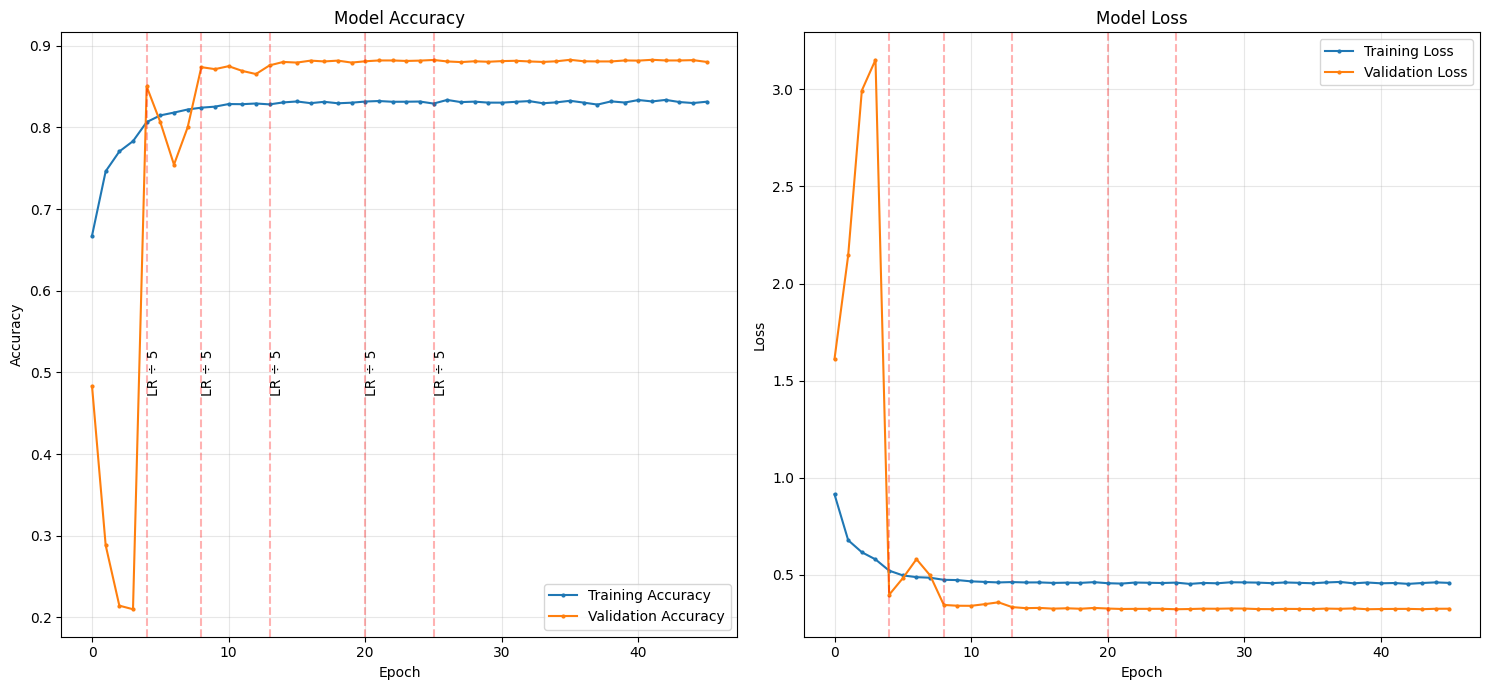

In [18]:
# Plot accuracy and loss with clear markers for learning rate changes
plt.figure(figsize=(15, 7))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o', markersize=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', markersize=2)

# Find points where learning rate changed
lr_changes = []
for i in range(1, len(history.history['lr'])):
    if history.history['lr'][i] < history.history['lr'][i-1]:
        lr_changes.append(i)

# Mark learning rate changes
for change in lr_changes:
    plt.axvline(x=change, color='r', linestyle='--', alpha=0.3)
    plt.text(change, 0.5, f"LR ÷ 5", rotation=90, verticalalignment='center')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o', markersize=2)
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', markersize=2)

# Mark learning rate changes on loss plot too
for change in lr_changes:
    plt.axvline(x=change, color='r', linestyle='--', alpha=0.3)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Add Confusion Matrix Analysis**

##### **Model Error Analysis**

The confusion matrix above shows the distribution of correct and incorrect classifications:
- Each row represents a true class
- Each column represents a predicted class
- The diagonal elements show correct classifications
- Off-diagonal elements show misclassifications

The most common errors typically occur between similar clothing items, such as:
- Shirts, T-shirts, and Pullovers
- Ankle boots and Sneakers
- Dresses and Coats

The classification report provides precision, recall, and F1-score for each class, helping identify which categories are most challenging for the model.

313/313 [==============================] - 1s 2ms/step


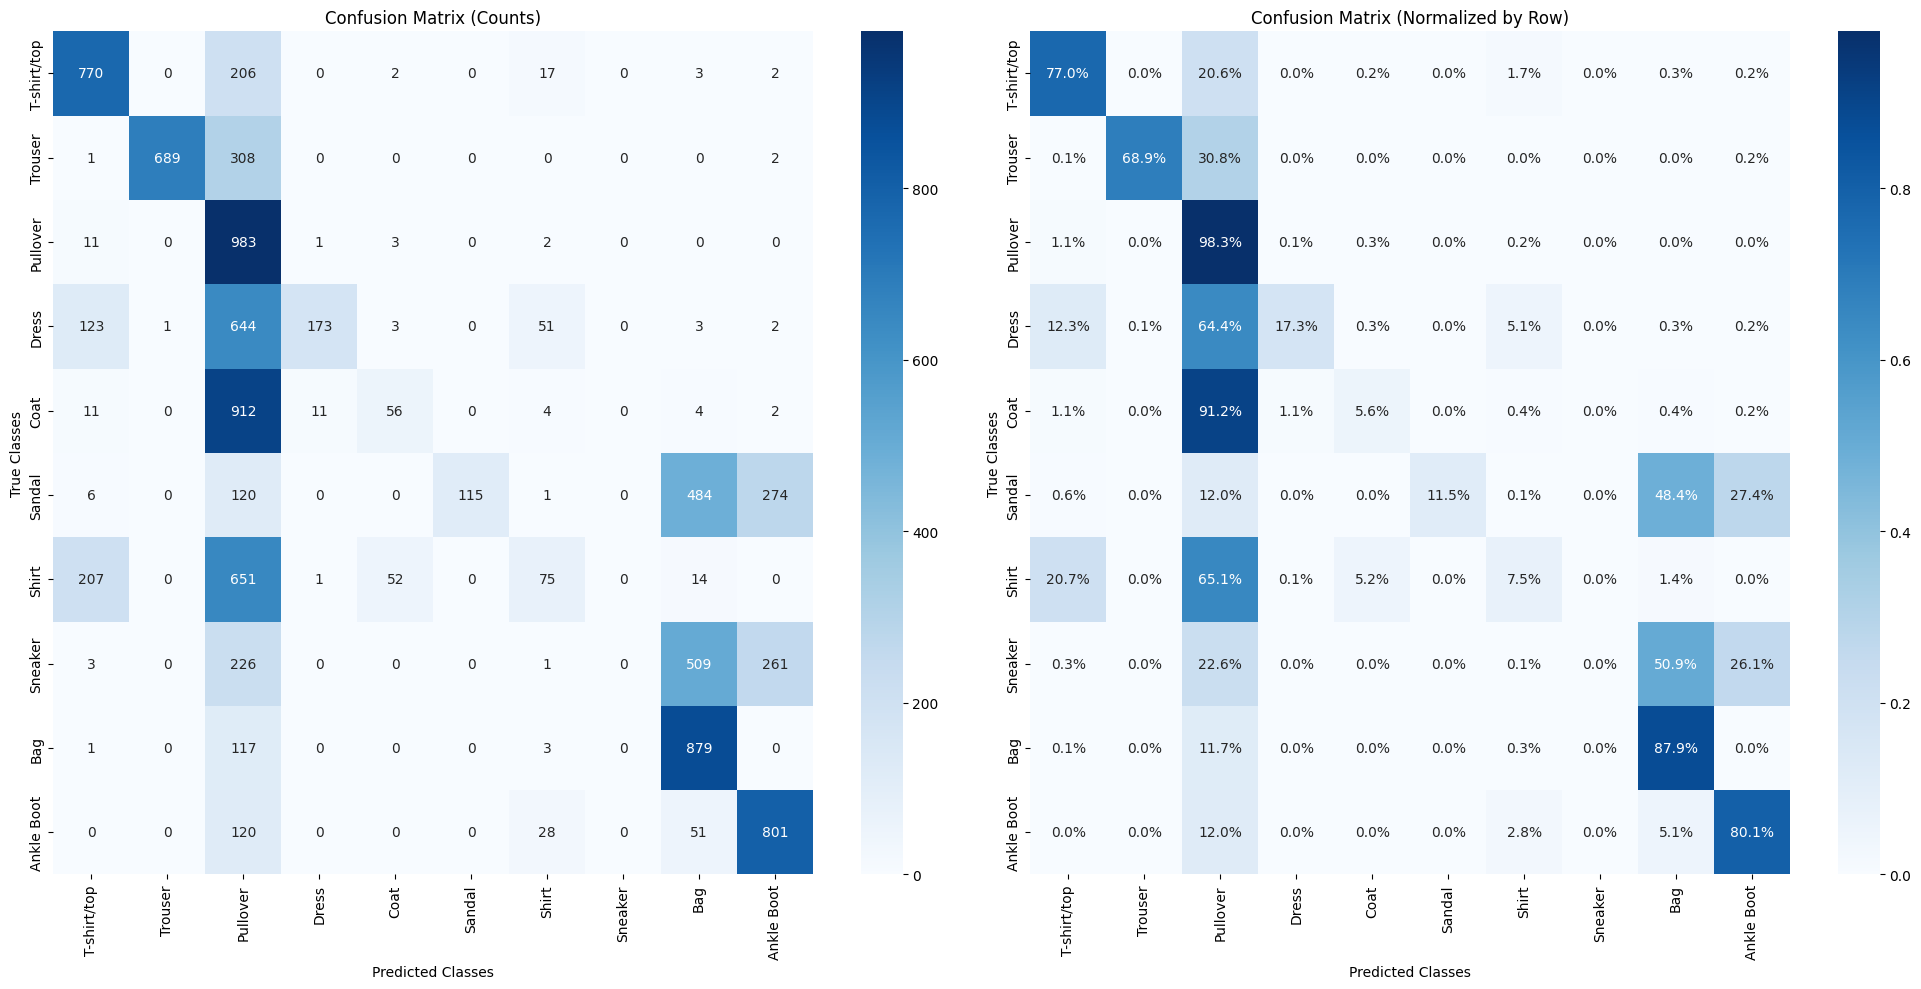


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.68      0.77      0.72      1000
     Trouser       1.00      0.69      0.82      1000
    Pullover       0.23      0.98      0.37      1000
       Dress       0.93      0.17      0.29      1000
        Coat       0.48      0.06      0.10      1000
      Sandal       1.00      0.12      0.21      1000
       Shirt       0.41      0.07      0.13      1000
     Sneaker       0.00      0.00      0.00      1000
         Bag       0.45      0.88      0.60      1000
  Ankle Boot       0.60      0.80      0.68      1000

    accuracy                           0.45     10000
   macro avg       0.58      0.45      0.39     10000
weighted avg       0.58      0.45      0.39     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Get predictions
X_test_shaped = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_pred_probs = model.predict(X_test_shaped)
y_pred = np.argmax(y_pred_probs, axis=1)

# Create figure with subplots for both raw and normalized confusion matrices
plt.figure(figsize=(20, 10))

# Raw counts confusion matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix (Counts)')

# Normalized confusion matrix (percentages)
plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix (Normalized by Row)')

plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

### **Error Analysis with Class Activation Maps**

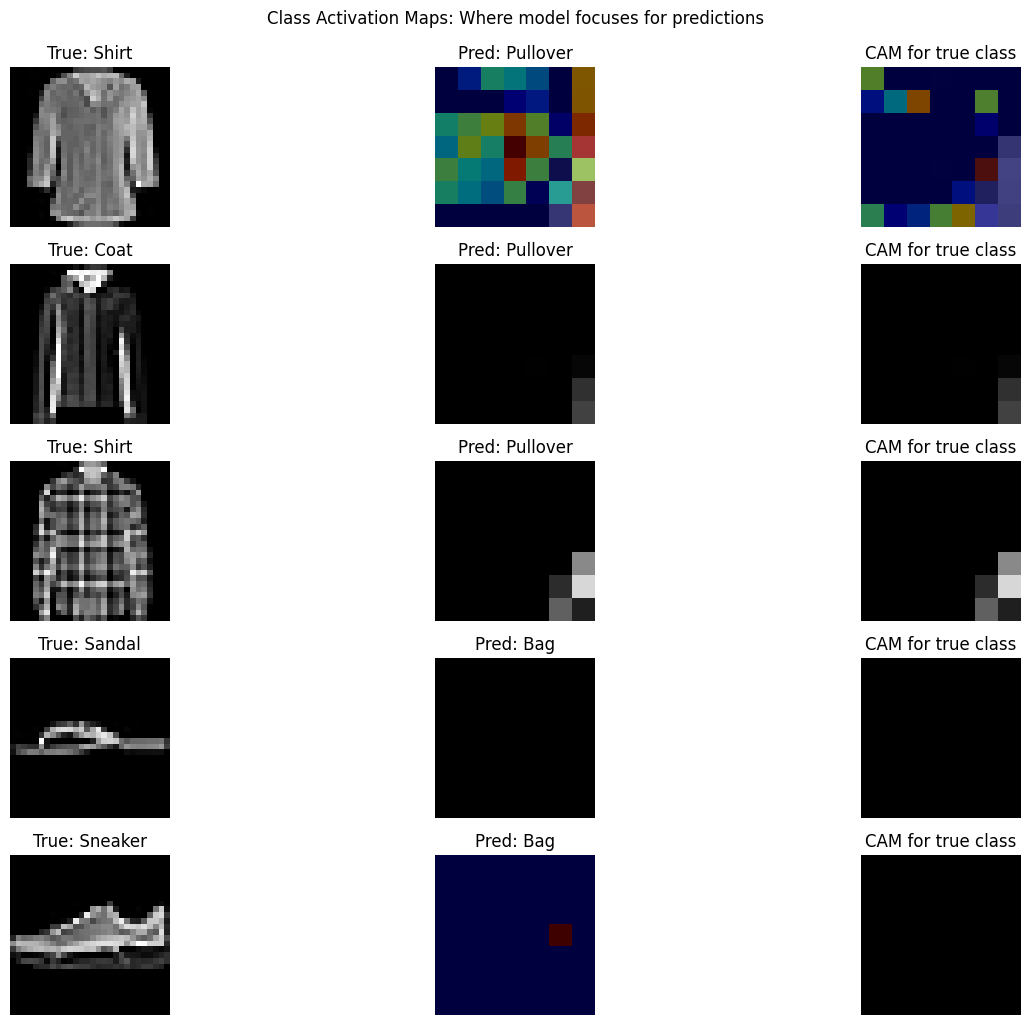

In [20]:
# Visualize Class Activation Maps (CAM) to understand model focus
def generate_cam(model, img, class_idx, layer_name=None):
    """Generate Class Activation Map for a specific image and class."""
    # If no layer is specified, use the last conv layer
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, Conv2D):
                layer_name = layer.name
                break
    
    # Get the class output and the specified convolutional layer output
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    # Gradient tape to compute gradients
    with tf.GradientTape() as tape:
        # Forward pass
        conv_output, predictions = grad_model(img[np.newaxis, ...])
        # Get logits for the specified class
        class_output = predictions[:, class_idx]
    
    # Gradients of the class output with respect to the conv output
    grads = tape.gradient(class_output, conv_output)
    
    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply the feature map with the gradient importance
    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)
    
    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

# Visualize CAM for misclassified examples
misclassified = np.where(y_pred != y_test)[0]
if len(misclassified) > 0:
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(misclassified[:5]):  # Show up to 5 examples
        # Original image
        plt.subplot(5, 3, 3*i+1)
        img = X_test[idx].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {class_names[y_test[idx]]}")
        plt.axis('off')
        
        # CAM for predicted class
        plt.subplot(5, 3, 3*i+2)
        pred_class = y_pred[idx]
        pred_cam = generate_cam(model, X_test_shaped[idx], pred_class)
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_cam, cmap='jet', alpha=0.5)
        plt.title(f"Pred: {class_names[pred_class]}")
        plt.axis('off')
        
        # CAM for true class
        plt.subplot(5, 3, 3*i+3)
        true_class = y_test[idx]
        true_cam = generate_cam(model, X_test_shaped[idx], true_class)
        plt.imshow(img, cmap='gray')
        plt.imshow(true_cam, cmap='jet', alpha=0.5)
        plt.title(f"CAM for true class")
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("Class Activation Maps: Where model focuses for predictions", y=1.02)
    plt.show()

### **Model Visualization**

##### **Prediction Visualization with Confidence**

Below is a visualization of model predictions on random test images:
- Green titles indicate correct classifications
- Red titles indicate misclassifications
- Confidence percentages show the model's certainty about each prediction
- This helps identify patterns in model errors and confidence levels

1/1 [==============================] - 0s 48ms/step


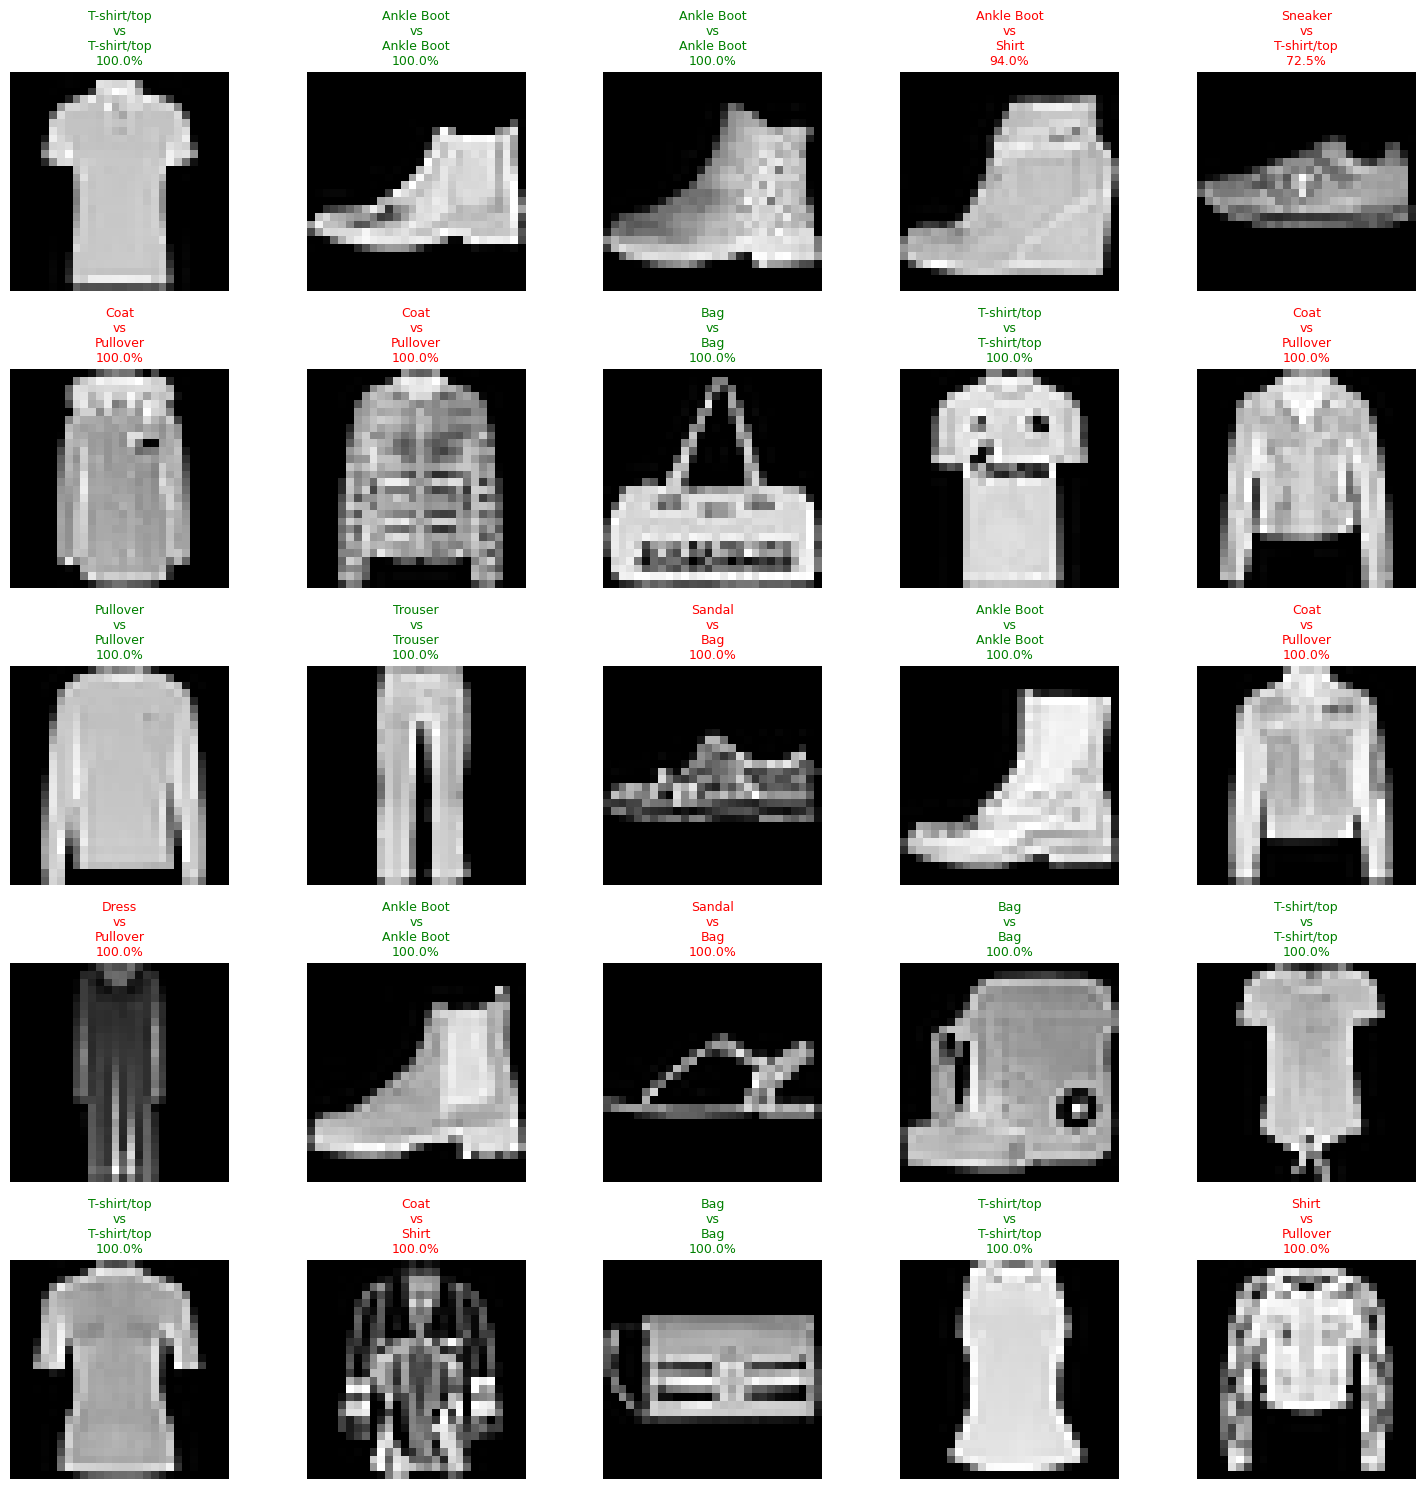

In [21]:
# Visualize model predictions with confidence scores
def plot_predictions_with_confidence(images, true_labels, predictions, class_names, n=25):
    plt.figure(figsize=(15, 15))
    for i in range(min(n, len(images))):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        
        predicted_class = np.argmax(predictions[i])
        confidence = predictions[i][predicted_class] * 100
        
        # Green for correct, red for incorrect
        color = 'green' if predicted_class == true_labels[i] else 'red'
        
        title = f"{class_names[true_labels[i]]}\nvs\n{class_names[predicted_class]}\n{confidence:.1f}%"
        plt.title(title, color=color, fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get random sample from test set
indices = np.random.choice(len(X_test), 25, replace=False)
sample_images = X_test[indices]
sample_labels = y_test[indices]
sample_images_shaped = sample_images.reshape(-1, 28, 28, 1)
sample_predictions = model.predict(sample_images_shaped)

# Visualize predictions with confidence
plot_predictions_with_confidence(sample_images, sample_labels, sample_predictions, class_names)

### **Loading Best Model**

* We first use `clear_session` to free up our memory and then delete the model.

In [22]:
keras.backend.clear_session

<function keras.backend.clear_session()>

In [23]:
del model

* Now we load the `Best model` that our `callback` saved.

In [25]:
model = load_model('./custom_model/best_model.h5')

### **Evaluating Model**

* Here we evaluate the overall `performance` of our model on the `Test Dataset`.

In [26]:
result = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 98.6628 - accuracy: 0.4557


In [27]:
result

[98.66283416748047, 0.45570001006126404]

### **Model Metadata**

In [28]:
# Create timestamp for model versioning
timestamp = time.strftime("%Y%m%d-%H%M%S")
export_path = f"./custom_model/fashion_mnist_model_{timestamp}"

# Define model metadata dictionary
model_metadata = {
    "model_name": "Fashion MNIST CNN",
    "version": timestamp,
    "architecture": "CNN with BatchNorm",
    "input_shape": [28, 28, 1],
    "classes": class_names,
    "performance": {
        "accuracy": float(result[1]),
        "loss": float(result[0])
    },
    "training_details": {
        "optimizer": "Adam with gradient clipping",
        "epochs_trained": len(history.history['loss']),
        "batch_size": 32,
        "data_augmentation": True
    }
}

### **Model Inference Time Profiling**

In [29]:
# Add after model evaluation to measure inference performance
def profile_inference_time(model, input_data, batch_size=32, num_warmup_runs=10, num_runs=100):
    """Profile model inference time for a given input."""
    # Ensure input is in correct format
    if len(input_data.shape) != 4:
        input_data = input_data.reshape(-1, 28, 28, 1)
    
    # Select subset of data for profiling (for efficiency)
    if len(input_data) > batch_size:
        indices = np.random.choice(len(input_data), batch_size, replace=False)
        input_batch = input_data[indices]
    else:
        input_batch = input_data
    
    print(f"Profiling inference time with batch size: {len(input_batch)}")
    
    # Warmup runs (to ensure TensorFlow optimization is applied)
    print("Performing warmup predictions...")
    for _ in range(num_warmup_runs):
        _ = model.predict(input_batch)
    
    # Timed runs
    print(f"Measuring inference time over {num_runs} runs...")
    start_time = time.time()
    for _ in range(num_runs):
        _ = model.predict(input_batch)
    end_time = time.time()
    
    # Calculate statistics
    total_time = end_time - start_time
    avg_time = total_time / num_runs
    imgs_per_sec = len(input_batch) / avg_time
    ms_per_img = 1000 * avg_time / len(input_batch)
    
    # Print results
    print(f"\nInference Performance:")
    print(f"  Total time for {num_runs} runs: {total_time:.3f} seconds")
    print(f"  Average time per batch: {avg_time*1000:.2f} ms")
    print(f"  Average time per image: {ms_per_img:.2f} ms")
    print(f"  Images per second: {imgs_per_sec:.1f}")
    
    return {
        "batch_size": len(input_batch),
        "runs": num_runs,
        "avg_batch_time_ms": avg_time*1000,
        "avg_image_time_ms": ms_per_img,
        "images_per_second": imgs_per_sec
    }

# Run profiling on test data
inference_metrics = profile_inference_time(model, X_test)

# Add inference metrics to model metadata
model_metadata["inference_performance"] = inference_metrics

Profiling inference time with batch size: 32
Performing warmup predictions...
1/1 [==============================] - 0s 14ms/step
Measuring inference time over 100 runs...
1/1 [==============================] - 0s 13ms/step

Inference Performance:
  Total time for 100 runs: 3.839 seconds
  Average time per batch: 38.39 ms
  Average time per image: 1.20 ms
  Images per second: 833.6


### **Test-Time Augmentation for Better Evaluation**

3/3 [==============================] - 0s 10ms/step

Test-Time Augmentation changed 55 predictions out of 87 low-confidence samples


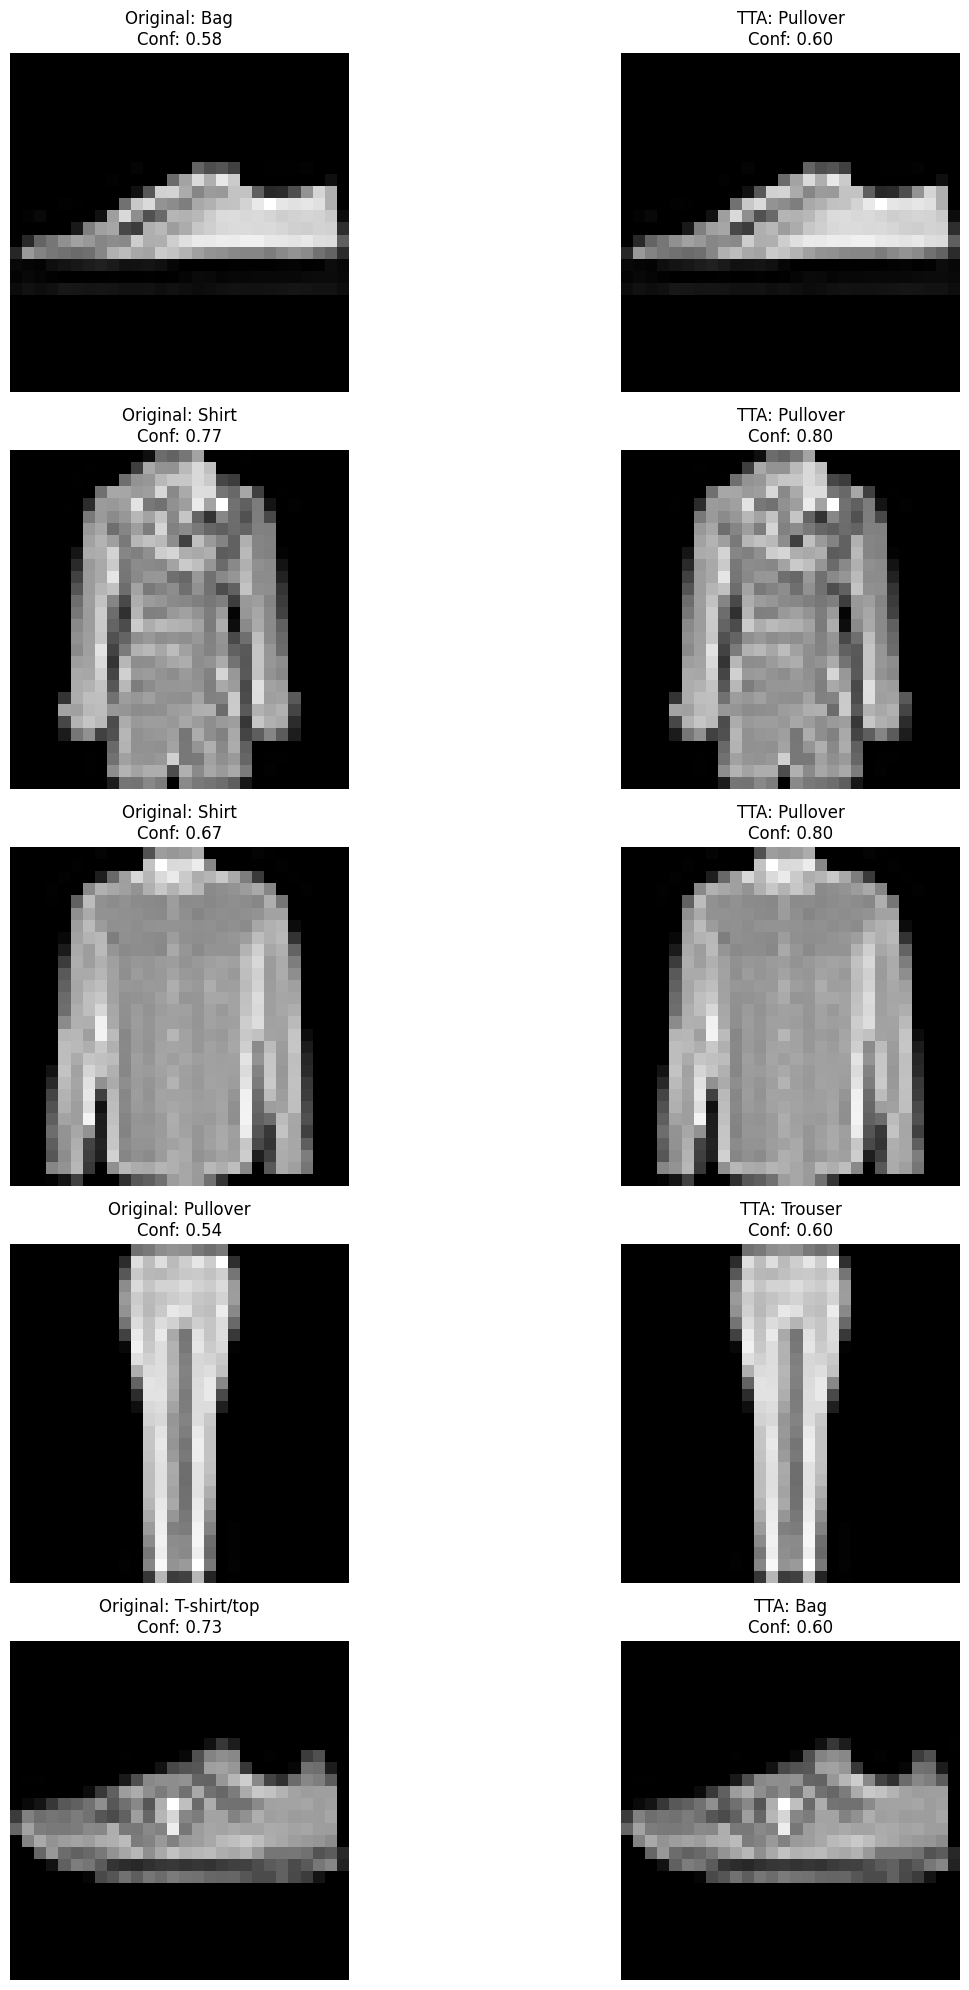

In [30]:
# Test-time augmentation to improve inference reliability
def test_time_augmentation(model, images, num_augmentations=10):
    """Apply multiple augmentations to test images and average predictions."""
    # Create a test-specific augmentation generator (with less aggressive transforms)
    test_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    predictions = []
    # Make multiple predictions with different augmentations
    for _ in range(num_augmentations):
        # Generate augmented versions
        aug_images = np.array([test_datagen.random_transform(img) for img in images])
        # Get predictions
        batch_preds = model.predict(aug_images)
        predictions.append(batch_preds)
    
    # Average predictions from all augmentations
    avg_predictions = np.mean(predictions, axis=0)
    return avg_predictions

# Apply test-time augmentation to a subset (e.g., difficult examples)
# Identify examples with low confidence predictions
low_confidence_mask = np.max(y_pred_probs, axis=1) < 0.8
low_confidence_indices = np.where(low_confidence_mask)[0]

if len(low_confidence_indices) > 0:
    # Select subset of low confidence predictions
    subset_indices = low_confidence_indices[:100]  # limit to 100 for efficiency
    subset_images = X_test_shaped[subset_indices]
    
    # Get regular predictions
    regular_preds = y_pred_probs[subset_indices]
    regular_classes = np.argmax(regular_preds, axis=1)
    
    # Get TTA predictions
    tta_preds = test_time_augmentation(model, subset_images, num_augmentations=5)
    tta_classes = np.argmax(tta_preds, axis=1)
    
    # Compare results
    changes = np.sum(regular_classes != tta_classes)
    print(f"\nTest-Time Augmentation changed {changes} predictions out of {len(subset_indices)} low-confidence samples")
    
    if changes > 0:
        # Show examples where TTA changed the prediction
        changed_indices = np.where(regular_classes != tta_classes)[0]
        plt.figure(figsize=(15, 4 * min(5, len(changed_indices))))
        
        for i, idx in enumerate(changed_indices[:5]):  # show up to 5 examples
            original_idx = subset_indices[idx]
            plt.subplot(min(5, len(changed_indices)), 2, 2*i+1)
            plt.imshow(X_test[original_idx].reshape(28, 28), cmap='gray')
            plt.title(f"Original: {class_names[regular_classes[idx]]}\nConf: {np.max(regular_preds[idx]):.2f}")
            plt.axis('off')
            
            plt.subplot(min(5, len(changed_indices)), 2, 2*i+2)
            plt.imshow(X_test[original_idx].reshape(28, 28), cmap='gray')
            plt.title(f"TTA: {class_names[tta_classes[idx]]}\nConf: {np.max(tta_preds[idx]):.2f}")
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

### **Predicting Classes**

* Now we will `predict classes` using our model.
* First we take a small subset from our `Test Dataset`.

In [31]:
X_new = X_test[:3]

* The we use predict function using our model on the subset.

In [32]:
y_pred = model.predict(X_new) 

1/1 [==============================] - 0s 63ms/step


* Rounding off to 2 Decimal digits.

In [33]:
y_pred = np.round(y_pred, 2)

* Making an array of the position of the highest number present in each list.

In [34]:
y_pred = np.argmax(y_pred, axis=1)

print(y_pred)

[9 2 1]


* Now we see the values in our Test Subset.

In [35]:
y_test[:3]

array([9, 2, 1], dtype=uint8)

* Our model predicted it accurately.

'''

* Let's Display the first image in our Subset.

AxesImage(shape=(28, 28))


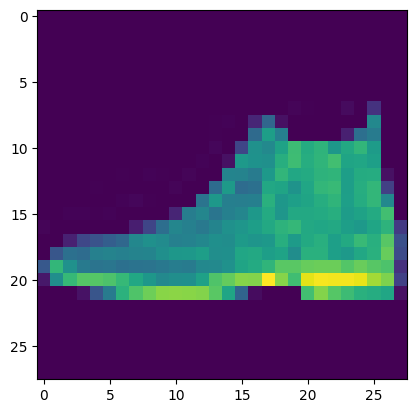

In [36]:
print(plt.imshow(X_test[0].reshape((28,28))))

* And the value model predicted for the first image was `9` which according to our `class_names` list is ...

In [37]:
class_names[9]

'Ankle Boot'

* Seems to match perfectly.

### **Model Export for Production Deployment**

In [39]:
# Run profiling and add to metadata
inference_metrics = profile_inference_time(model, X_test)
model_metadata["inference_performance"] = inference_metrics

# Save in both formats with consolidated metadata
model.save(export_path, save_format='tf')
model.save(f"./custom_model/fashion_mnist_model_{timestamp}.h5")

# Save metadata
with open(os.path.join(export_path, "model_metadata.json"), "w") as f:
    json.dump(model_metadata, f, indent=2)
    
print(f"Model saved to {export_path} in both SavedModel and H5 formats")
print("Model metadata saved.")

Profiling inference time with batch size: 32
Performing warmup predictions...
1/1 [==============================] - 0s 15ms/step
Measuring inference time over 100 runs...
1/1 [==============================] - 0s 12ms/step

Inference Performance:
  Total time for 100 runs: 5.257 seconds
  Average time per batch: 52.57 ms
  Average time per image: 1.64 ms
  Images per second: 608.7


2025-05-01 15:45:22.873636: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,14,14,32]
	 [[{{node inputs}}]]
2025-05-01 15:45:22.890696: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,7,7,64]
	 [[{{node inputs}}]]
2025-05-01 15:45:22.906454: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,3,3,128]
	 [[{{node inputs}}]]
2025

INFO:tensorflow:Assets written to: ./custom_model/fashion_mnist_model_20250501-154321/assets


INFO:tensorflow:Assets written to: ./custom_model/fashion_mnist_model_20250501-154321/assets


Model saved to ./custom_model/fashion_mnist_model_20250501-154321 in both SavedModel and H5 formats
Model metadata saved.


***
***